In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os
import tensorflow as tf
import cv2
import glob
import datetime as dt
RANDOM_SEED = 9999

import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.metrics import Accuracy


color_width=64
color_height=64

gry_width=128
gry_height=128


curses is not supported on this machine (please install/reinstall curses for an optimal experience)








In [2]:
def read_file(file, color=True):
    if(color==True):
        return cv2.cvtColor(cv2.imread(file,cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB)
    else:
        return cv2.imread(file,cv2.IMREAD_GRAYSCALE)
    
def show_image(img, color=True):
    if(color==True):
        plt.imshow(img)
    else:
        plt.imshow(img,cmap='gray')
    plt.show()

def parse_resize(file,size,color=True):
    if(color==True):
        image= cv2.cvtColor(cv2.imread(file,cv2.IMREAD_COLOR),cv2.COLOR_BGR2RGB)
    else:
        image= cv2.imread(file,cv2.IMREAD_GRAYSCALE)
    return cv2.resize(image,size)

def reset(seed=RANDOM_SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [3]:
train_cat_files=glob.glob('train/cat.[0-9]*.jpg')

In [4]:
train_dog_files=glob.glob('train/dog.[0-9]*.jpg')

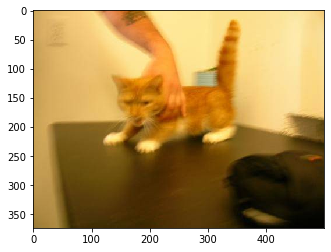

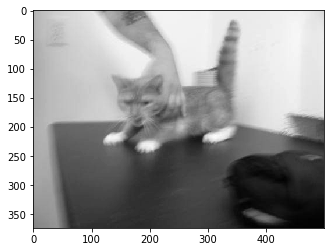

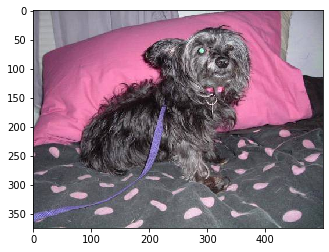

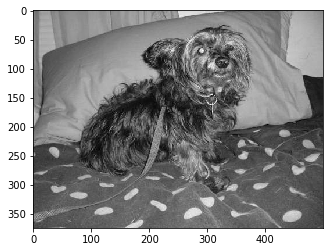

In [5]:
show_image(read_file(train_cat_files[0],True),True)
show_image(read_file(train_cat_files[0],False),False)

show_image(read_file(train_dog_files[0],True),True)
show_image(read_file(train_dog_files[0],False),False)

In [6]:
train_data =[]

for file in range(len(train_cat_files)):
    train_data.append([np.array(parse_resize(train_cat_files[file],(gry_width,gry_height),False)),np.array([1,0])])

for file in range(len(train_dog_files)):
    train_data.append([np.array(parse_resize(train_dog_files[file],(gry_width,gry_height),False)),np.array([0,1])])



In [7]:
# reshape data
train_x = np.array([i[0] for i in train_data]).reshape(-1, gry_width, gry_height, 1)
train_y = [i[1] for i in train_data]

train_x.shape

(25000, 128, 128, 1)

In [8]:
# Getting test data ready
test_files=glob.glob('test/*.jpg')

test_data=[]
for file in range(len(test_files)):
    test_data.append([np.array(parse_resize(test_files[file],(gry_width,gry_height),False)),test_files[file].split('.')[0]])


In [9]:
from sklearn.model_selection import train_test_split
x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [44]:
%%time

tf.reset_default_graph()

LR = 1e-3

# Input
m1_network = input_data(shape=[None, gry_width, gry_height, 1], name='input')

m1_network = conv_2d(m1_network, 32, 5, activation='relu')

m1_network = max_pool_2d(m1_network, 5)

m1_network = conv_2d(m1_network, 64, 5, activation='relu')

m1_network = max_pool_2d(m1_network, 5)

m1_network = conv_2d(m1_network, 128, 5, activation='relu')

m1_network = max_pool_2d(m1_network, 5)

m1_network = conv_2d(m1_network, 64, 5, activation='relu')

m1_network = max_pool_2d(m1_network, 5)

m1_network = conv_2d(m1_network, 32, 5, activation='relu')

m1_network = max_pool_2d(m1_network, 5)

m1_network = fully_connected(m1_network, 1024, activation='relu')

m1_network = dropout(m1_network, 0.8)

m1_network = fully_connected(m1_network, 2, activation='softmax')

m1_network = regression(m1_network, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', metric=Accuracy(name="Accuracy"))

model_1 = tflearn.DNN(m1_network, tensorboard_dir='log', tensorboard_verbose=0)

model1_start=dt.datetime.now()

model_1.fit(x_train_1,y_train_1, n_epoch=10, validation_set=(x_test_1,y_test_1), 
          snapshot_step=500, show_metric=True, run_id="model_1")

model1_end=dt.datetime.now()
model1_time=model1_end-model1_start
model1_time

Training Step: 3129  | total loss: 0.19961 | time: 101.186s
| Adam | epoch: 010 | loss: 0.19961 - Accuracy: 0.9159 -- iter: 19968/20000
Training Step: 3130  | total loss: 0.19160 | time: 108.272s
| Adam | epoch: 010 | loss: 0.19160 - Accuracy: 0.9211 | val_loss: 0.60347 - val_acc: 0.8072 -- iter: 20000/20000
--
Wall time: 17min 41s


datetime.timedelta(seconds=1060, microseconds=386133)

In [45]:
df_1 = pd.DataFrame({'id': [], 'label': []})

for num, data in enumerate(test_data):
    img_data = data[0].reshape(gry_width, gry_height, 1)
    model_out = model_1.predict([img_data])[0]
    
    df_1 = df_1.append({'id': data[1].split('\\')[1], 'label': np.argmax(model_out)}, ignore_index=True)
    
df_1.to_csv('CNN_Model_1.csv', index=False)

In [11]:
%%time

tf.reset_default_graph()

LR = 1e-3
m2_network = input_data(shape=[None, gry_width, gry_height, 1], name='input')

m2_network = conv_2d(m2_network, 32, 5, activation='relu')

m2_network = max_pool_2d(m2_network, 5)

m2_network = conv_2d(m2_network, 64, 5, activation='relu')

m2_network = max_pool_2d(m2_network, 5)

m2_network = conv_2d(m2_network, 128, 5, activation='relu')

m2_network = max_pool_2d(m2_network, 5)

m2_network = conv_2d(m2_network, 64, 5, activation='relu')

m2_network = max_pool_2d(m2_network, 5)

m2_network = conv_2d(m2_network, 32, 5, activation='relu')

m2_network = max_pool_2d(m2_network, 5)

m2_network = fully_connected(m2_network, 1024, activation='relu')

m2_network = dropout(m2_network, 0.75)

m2_network = fully_connected(m2_network, 2, activation='softmax')

m2_network = regression(m2_network, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')
model_2 = tflearn.DNN(m2_network, tensorboard_dir='log', tensorboard_verbose=0)

model2_start=dt.datetime.now()

model_2.fit(x_train_1,y_train_1, n_epoch=20, validation_set=(x_test_1,y_test_1), 
          snapshot_step=500, show_metric=True, run_id="model_2")

model2_end=dt.datetime.now()
model2_time=model2_end-model2_start
model2_time

Training Step: 6259  | total loss: 0.17684 | time: 99.245s
| Adam | epoch: 020 | loss: 0.17684 - acc: 0.9624 -- iter: 19968/20000
Training Step: 6260  | total loss: 0.16500 | time: 106.586s
| Adam | epoch: 020 | loss: 0.16500 - acc: 0.9646 | val_loss: 0.76112 - val_acc: 0.7950 -- iter: 20000/20000
--
Wall time: 34min 54s


datetime.timedelta(seconds=2094, microseconds=118625)

In [12]:
df_2 = pd.DataFrame({'id': [], 'label': []})

for num, data in enumerate(test_data):
    img_data = data[0].reshape(gry_width, gry_height, 1)
    model_out = model_2.predict([img_data])[0]
    
    df_2 = df_2.append({'id': data[1], 'label': np.argmax(model_out)}, ignore_index=True)
    
df_2.to_csv('CNN_Model_2.csv', index=False)

In [13]:
%%time
tf.reset_default_graph()
LR = 1e-3

m3_network = input_data(shape=[None, gry_width, gry_height, 1], name='input')
m3_network = conv_2d(m3_network, 32, 10, activation='relu')
m3_network = max_pool_2d(m3_network, 5)

m3_network = conv_2d(m3_network, 64, 10, activation='relu')
m3_network = max_pool_2d(m3_network, 5)

m3_network = conv_2d(m3_network, 128, 10, activation='relu')
m3_network = max_pool_2d(m3_network, 5)

m3_network = conv_2d(m3_network, 64, 10, activation='relu')
m3_network = max_pool_2d(m3_network, 5)

m3_network = conv_2d(m3_network, 32, 10, activation='relu')
m3_network = max_pool_2d(m3_network, 5)

m3_network = fully_connected(m3_network, 1024, activation='relu')
m3_network = dropout(m3_network, 0.8)

m3_network = fully_connected(m3_network, 2, activation='softmax')
m3_network = regression(m3_network, optimizer='SGD', learning_rate=LR, loss='categorical_crossentropy', name='targets')
model_3 = tflearn.DNN(m3_network, tensorboard_dir='log', tensorboard_verbose=0)

model3_start=dt.datetime.now()
model_3.fit(x_train_1,y_train_1, n_epoch=10, 
          validation_set=(x_test_1,y_test_1), 
          snapshot_step=500, show_metric=True, run_id="model_3")
model3_end=dt.datetime.now()
model3_time=model3_end-model3_start
model3_time

Training Step: 3129  | total loss: 0.61393 | time: 257.460s
| SGD | epoch: 010 | loss: 0.61393 - acc: 0.6690 -- iter: 19968/20000
Training Step: 3130  | total loss: 0.61451 | time: 272.474s
| SGD | epoch: 010 | loss: 0.61451 - acc: 0.6693 | val_loss: 0.60127 - val_acc: 0.6746 -- iter: 20000/20000
--
Wall time: 44min 36s


datetime.timedelta(seconds=2675, microseconds=423713)

In [14]:
df_3 = pd.DataFrame({'id': [], 'label': []})

for num, data in enumerate(test_data):
    img_data = data[0].reshape(gry_width, gry_height, 1)
    model_out = model_3.predict([img_data])[0]
    
    df_3 = df_3.append({'id': data[1].split('\\')[1], 'label': np.argmax(model_out)}, ignore_index=True)
    
df_3.to_csv('CNN_Model_3.csv', index=False)

In [16]:
%%time
tf.reset_default_graph()
m4_network = input_data(shape=[None, gry_width, gry_height, 1], name='input')

m4_network = conv_2d(m4_network, 32, 3, activation='relu')
m4_network = max_pool_2d(m4_network, 2)

m4_network = conv_2d(m4_network, 64, 3, activation='relu')

m4_network = conv_2d(m4_network, 64, 3, activation='relu')
m4_network = max_pool_2d(m4_network, 2)

m4_network = fully_connected(m4_network, 512, activation='relu')
m4_network = dropout(m4_network, 0.5)

m4_network = fully_connected(m4_network, 2, activation='softmax')

m4_network = regression(m4_network, optimizer='adam', learning_rate=0.75, loss='binary_crossentropy', name='targets')
model_4 = tflearn.DNN(m4_network, tensorboard_dir='log', tensorboard_verbose=0)

model4_start=dt.datetime.now()
model_4.fit(x_train_1, y_train_1, n_epoch=10, 
          validation_set=(x_test_1, y_test_1), 
          snapshot_step=500, show_metric=True, run_id="model 4")

model4_end=dt.datetime.now()
model4_time=model4_end-model4_start
model4_time

Training Step: 3129  | total loss: 0.76386 | time: 286.611s
| Adam | epoch: 010 | loss: 0.76386 - acc: 0.4787 -- iter: 19968/20000
Training Step: 3130  | total loss: 0.76045 | time: 304.256s
| Adam | epoch: 010 | loss: 0.76045 - acc: 0.4855 | val_loss: 0.75170 - val_acc: 0.5030 -- iter: 20000/20000
--
Wall time: 50min 37s


datetime.timedelta(seconds=3035, microseconds=726307)

In [17]:
df_4 = pd.DataFrame({'id': [], 'label': []})

for num, data in enumerate(test_data):
    img_data = data[0].reshape(gry_width, gry_height, 1)
    model_out = model_4.predict([img_data])[0]
    
    df_4 = df_4.append({'id': data[1].split('\\')[1], 'label': np.argmax(model_out)}, ignore_index=True)
    
df_4.to_csv('CNN_Model_4.csv', index=False)